In [1]:
from scipy import signal
import numpy as np
from scipy.fftpack import fft, ifft
import pandas as pd

import matplotlib
matplotlib.use('nbagg')
from pylab import rcParams
rcParams['figure.figsize'] = 9, 4
import matplotlib.pyplot as plt
import scipy

%load_ext autoreload
%autoreload 2
import sys
import copy

from pyha import Hardware, simulate, sims_close, Complex, resize, hardware_sims_equal
from pathlib import Path
from data import load_iq

def imshow(im):
    from skimage.exposure import exposure
    p2, p98 = np.percentile(im, (2, 98))
    im = exposure.rescale_intensity(im, in_range=(p2, p98))

    
    plt.imshow(im, interpolation='nearest', aspect='auto', origin='lower')
    plt.tight_layout()
    plt.show()
    
    
def snr(pure, noisy):
    sig_pow = np.mean(np.abs(pure))
    error = np.array(pure) - np.array(noisy)
    err_pow = np.mean(np.abs(error))
    
    snr_db = 20*np.log10(sig_pow/err_pow)
    return snr_db

from under_construction.fft.bit_reversal_fftshift import bit_reversed_indexes
from under_construction.fft.fft_core import R2SDFSFIX, R2SDF
from under_construction.fft.packager import DataWithIndex, unpackage, package

def show_freqz(taps):
    w, h = scipy.signal.freqz(taps)
    fig, ax1 = plt.subplots(1, 1)
    plt.title('Digital filter frequency response')
    ax1.plot(w / np.pi, 20 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency')
    plt.grid()
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w / np.pi, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')
    ax2.axis('tight')
    plt.tight_layout()
    plt.show()
    
def show_plot():
    plt.tight_layout()
    plt.grid()
    if plt.gca().get_legend_handles_labels() != ([], []):
        plt.legend()
    plt.show()
    
def bit_reverse(x, n_bits):
    return int(np.binary_repr(x, n_bits)[::-1], 2)

def bit_reversed_indexes(N):
    return [bit_reverse(i, int(np.log2(N))) for i in range(N)]

from pyha import Hardware, simulate, sims_close, Complex, Sfix
from pyha.common.float import *
from mpmath import mp 

In [45]:
fft_size = 1024 * 2 * 2 * 2

In [46]:
hann_fix9 = np.array([Sfix(x, 0, -8, round_style='round', overflow_style='saturate').val for x in  np.hanning(fft_size)])

In [60]:
# sig = np.exp(2j*np.pi*np.linspace(0, 1, fft_size) * 100) * 0.25
# sig = sig * hann_fix9

# sig2 = np.exp(2j*np.pi*np.linspace(0, 1, fft_size) * 110) * 0.25
# sig2 = sig2 * hann_fix9

# sig = sig + sig2

sig = np.exp(2j*np.pi*np.linspace(0, 1, fft_size) * 1000)
for i in range(800, 1000, 2):
    sig2 = np.exp(2j*np.pi*np.linspace(0, 1, fft_size) * i * -1)
    sig = sig + sig2

sig *= 1 / 2 / 2 / 2 /2 / 2 / 2 / 2 / 2 / 2 /2 /2 /2 /2 /2 / 2
# sig = np.array([Complex(x, 0, -11, overflow_style='saturate').val for x in  sig]) # simulate ADC
sig *= np.hamming(fft_size)
# sig_fix *= hann_fix9

/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


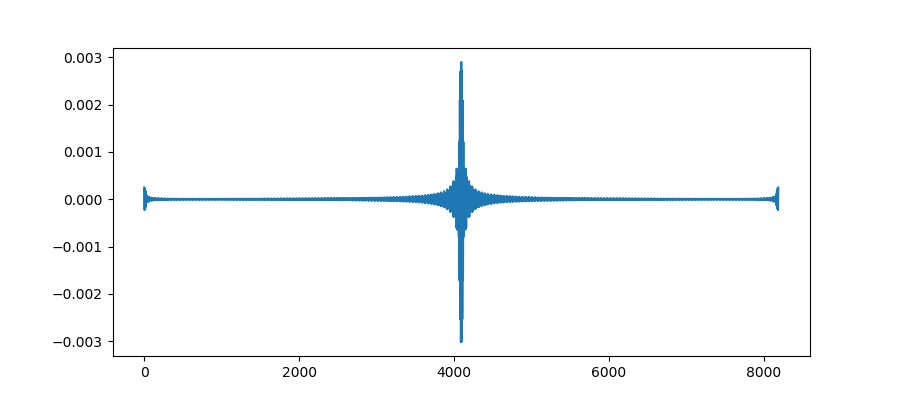

<IPython.core.display.Javascript object>


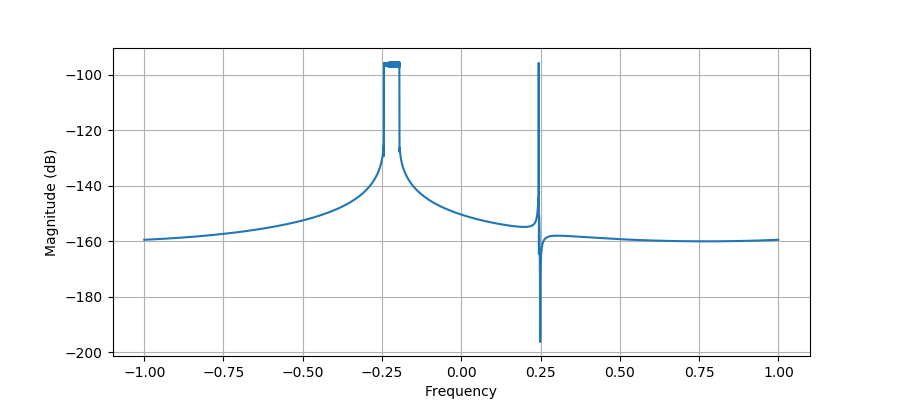

In [61]:
plt.plot(sig)
plt.show()

plt.magnitude_spectrum(sig, window=matplotlib.mlab.window_none, scale='dB')
plt.grid()
plt.show()

In [55]:
# with Sfix._float_mode:
dut = R2SDFSFIX(fft_size)
# with Sfix._float_mode:
# sigi = [Complex(x, 0, -5) for x in sig]
sims = simulate(dut, sig, simulations=['PYHA'], output_callback=unpackage, input_callback=package)

INFO:sim:Converting model to hardware types ...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 16384/16384 [00:27<00:00, 597.23it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


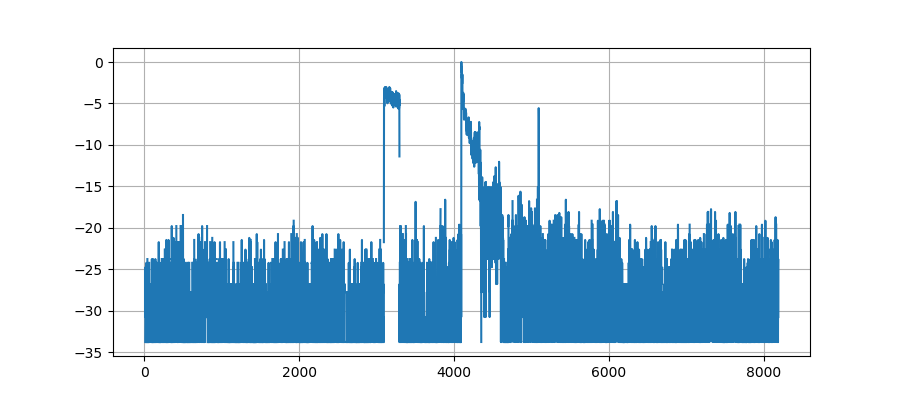

In [56]:
pyh = np.array(sims['PYHA'][0])
pyh = pyh[bit_reversed_indexes(fft_size)]
pyh = np.fft.fftshift(pyh)
pyh = np.abs(pyh)
pyh = pyh / pyh.max()

a = 20 * np.log10(pyh)
plt.plot(a)
plt.grid()
plt.show()

In [79]:
dut = R2SDF(fft_size)
sims = simulate(dut, sig, input_types=[ComplexFloat()], simulations=['PYHA'], output_callback=unpackage, input_callback=package)

INFO:sim:Converting model to hardware types ...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


 25%|██▍       | 4089/16384 [00:09<00:29, 411.03it/s]

 26%|██▋       | 4321/16384 [00:10<00:29, 413.28it/s]

 27%|██▋       | 4364/16384 [00:10<00:29, 413.30it/s]

 28%|██▊       | 4616/16384 [00:11<00:28, 412.53it/s]

 29%|██▊       | 4701/16384 [00:11<00:28, 412.72it/s]

 29%|██▉       | 4784/16384 [00:11<00:28, 412.54it/s]

 30%|██▉       | 4866/16384 [00:11<00:27, 411.92it/s]

 32%|███▏      | 5234/16384 [00:12<00:27, 410.39it/s]

 32%|███▏      | 5316/16384 [00:12<00:26, 410.12it/s]

 33%|███▎      | 5394/16384 [00:13<00:26, 408.75it/s]

 33%|███▎      | 5468/16384 [00:13<00:26, 407.63it/s]

 34%|███▍      | 5581/16384 [00:13<00:26, 406.79it/s]

 34%|███▍      | 5618/16384 [00:13<00:26, 406.13it/s]

 35%|███▍      | 5654/16384 [00:13<00:26, 405.55it/s]

 35%|███▍      | 5733/16384 [00:14<00:26, 405.34it/s]

 36%|███▌      | 5845/16384 [00:14<00:26, 404.38it/s]

 36%|███▌      | 5920/16384 [00:14<00:25, 403.47it/s]

 36%|███▋      | 5956/16384 [00:14<00:25, 403.15it/s]

 37%|███▋      | 5992/16384 [00:14<00:25, 402.46it/s]

 37%|███▋      | 6027/16384 [00:14<00:25, 401.81it/s]

 37%|███▋      | 6061/16384 [00:15<00:25, 401.15it/s]

 37%|███▋      | 6094/16384 [00:15<00:25, 399.90it/s]

 37%|███▋      | 6125/16384 [00:15<00:25, 399.03it/s]

 38%|███▊      | 6155/16384 [00:15<00:25, 398.11it/s]

 38%|███▊      | 6192/16384 [00:15<00:25, 397.88it/s]

 38%|███▊      | 6232/16384 [00:15<00:25, 397.84it/s]

 38%|███▊      | 6270/16384 [00:15<00:25, 397.66it/s]

 39%|███▊      | 6310/16384 [00:15<00:25, 397.67it/s]

 39%|███▊      | 6348/16384 [00:15<00:25, 397.52it/s]

 39%|███▉      | 6385/16384 [00:16<00:25, 397.28it/s]

 39%|███▉      | 6423/16384 [00:16<00:25, 397.09it/s]

 40%|███▉      | 6497/16384 [00:16<00:24, 396.40it/s]

 40%|████      | 6607/16384 [00:16<00:24, 395.45it/s]

 41%|████      | 6643/16384 [00:16<00:24, 395.03it/s]

 41%|████      | 6681/16384 [00:16<00:24, 394.93it/s]

 41%|████      | 6758/16384 [00:17<00:24, 394.74it/s]

 42%|████▏     | 6832/16384 [00:17<00:24, 394.17it/s]

 42%|████▏     | 6868/16384 [00:17<00:24, 393.82it/s]

 42%|████▏     | 6904/16384 [00:17<00:24, 393.42it/s]

 42%|████▏     | 6941/16384 [00:17<00:24, 393.26it/s]

 43%|████▎     | 7013/16384 [00:17<00:23, 392.77it/s]

 43%|████▎     | 7084/16384 [00:18<00:23, 392.13it/s]

 43%|████▎     | 7119/16384 [00:18<00:23, 391.75it/s]

 44%|████▎     | 7153/16384 [00:18<00:23, 391.27it/s]

 44%|████▍     | 7188/16384 [00:18<00:23, 391.00it/s]

 44%|████▍     | 7226/16384 [00:18<00:23, 390.93it/s]

 44%|████▍     | 7263/16384 [00:18<00:23, 390.81it/s]

 45%|████▌     | 7374/16384 [00:18<00:23, 390.32it/s]

 46%|████▌     | 7482/16384 [00:19<00:22, 389.52it/s]

 46%|████▌     | 7552/16384 [00:19<00:22, 388.95it/s]

 46%|████▋     | 7587/16384 [00:19<00:22, 388.75it/s]

 47%|████▋     | 7622/16384 [00:19<00:22, 388.37it/s]

 47%|████▋     | 7656/16384 [00:19<00:22, 387.95it/s]

 47%|████▋     | 7689/16384 [00:19<00:22, 387.53it/s]

 48%|████▊     | 7864/16384 [00:20<00:22, 386.33it/s]

 48%|████▊     | 7931/16384 [00:20<00:21, 385.54it/s]

 50%|████▉     | 8129/16384 [00:21<00:21, 383.43it/s]

 55%|█████▌    | 9076/16384 [00:23<00:18, 387.56it/s]

 59%|█████▉    | 9690/16384 [00:24<00:17, 389.21it/s]

 59%|█████▉    | 9731/16384 [00:25<00:17, 389.05it/s]

 62%|██████▏   | 10138/16384 [00:26<00:16, 388.85it/s]

 63%|██████▎   | 10297/16384 [00:26<00:15, 388.66it/s]

 65%|██████▍   | 10601/16384 [00:27<00:14, 389.53it/s]

 68%|██████▊   | 11133/16384 [00:28<00:13, 389.37it/s]

 68%|██████▊   | 11208/16384 [00:28<00:13, 389.04it/s]

 69%|██████▊   | 11244/16384 [00:28<00:13, 388.82it/s]

 69%|██████▉   | 11280/16384 [00:29<00:13, 388.53it/s]

 71%|███████   | 11600/16384 [00:29<00:12, 388.54it/s]

 72%|███████▏  | 11752/16384 [00:30<00:11, 388.03it/s]

 72%|███████▏  | 11788/16384 [00:30<00:11, 387.85it/s]

 73%|███████▎  | 11902/16384 [00:30<00:11, 387.68it/s]

 73%|███████▎  | 11976/16384 [00:30<00:11, 387.48it/s]

 74%|███████▎  | 12048/16384 [00:31<00:11, 387.11it/s]

 74%|███████▍  | 12189/16384 [00:31<00:10, 386.47it/s]

 75%|███████▌  | 12290/16384 [00:31<00:10, 385.76it/s]

 76%|███████▋  | 12512/16384 [00:32<00:10, 386.57it/s]

 77%|███████▋  | 12554/16384 [00:32<00:09, 386.62it/s]

 78%|███████▊  | 12804/16384 [00:33<00:09, 386.76it/s]

 79%|███████▊  | 12890/16384 [00:33<00:09, 386.99it/s]

 79%|███████▉  | 12972/16384 [00:33<00:08, 387.01it/s]

 79%|███████▉  | 13012/16384 [00:33<00:08, 386.96it/s]

 80%|███████▉  | 13051/16384 [00:33<00:08, 386.85it/s]

 80%|███████▉  | 13091/16384 [00:33<00:08, 386.87it/s]

 82%|████████▏ | 13446/16384 [00:34<00:07, 386.59it/s]

 83%|████████▎ | 13527/16384 [00:34<00:07, 386.62it/s]

 83%|████████▎ | 13567/16384 [00:35<00:07, 386.49it/s]

 83%|████████▎ | 13608/16384 [00:35<00:07, 386.55it/s]

 84%|████████▎ | 13686/16384 [00:35<00:06, 386.38it/s]

 84%|████████▍ | 13761/16384 [00:35<00:06, 386.03it/s]

 84%|████████▍ | 13797/16384 [00:35<00:06, 385.83it/s]

 84%|████████▍ | 13832/16384 [00:35<00:06, 385.57it/s]

 85%|████████▍ | 13910/16384 [00:36<00:06, 385.58it/s]

 85%|████████▌ | 13946/16384 [00:36<00:06, 385.48it/s]

 86%|████████▌ | 14019/16384 [00:36<00:06, 385.32it/s]

 86%|████████▌ | 14055/16384 [00:36<00:06, 385.13it/s]

 86%|████████▌ | 14090/16384 [00:36<00:05, 384.96it/s]

 86%|████████▌ | 14127/16384 [00:36<00:05, 384.90it/s]

 86%|████████▋ | 14162/16384 [00:36<00:05, 384.70it/s]

 87%|████████▋ | 14196/16384 [00:36<00:05, 384.43it/s]

 87%|████████▋ | 14229/16384 [00:37<00:05, 384.27it/s]

 87%|████████▋ | 14262/16384 [00:37<00:05, 384.05it/s]

 87%|████████▋ | 14295/16384 [00:37<00:05, 383.77it/s]

 87%|████████▋ | 14327/16384 [00:37<00:05, 383.35it/s]

 88%|████████▊ | 14357/16384 [00:37<00:05, 383.05it/s]

 88%|████████▊ | 14394/16384 [00:37<00:05, 383.00it/s]

 88%|████████▊ | 14430/16384 [00:37<00:05, 382.92it/s]

 88%|████████▊ | 14464/16384 [00:37<00:05, 382.80it/s]

 89%|████████▊ | 14502/16384 [00:37<00:04, 382.78it/s]

 89%|████████▊ | 14537/16384 [00:37<00:04, 382.68it/s]

 89%|████████▉ | 14572/16384 [00:38<00:04, 382.56it/s]

 89%|████████▉ | 14607/16384 [00:38<00:04, 382.46it/s]

 90%|████████▉ | 14721/16384 [00:38<00:04, 382.36it/s]

 90%|█████████ | 14795/16384 [00:38<00:04, 382.24it/s]

 91%|█████████ | 14831/16384 [00:38<00:04, 382.09it/s]

 91%|█████████ | 14868/16384 [00:38<00:03, 382.04it/s]

 91%|█████████ | 14906/16384 [00:39<00:03, 382.02it/s]

 91%|█████████▏| 14980/16384 [00:39<00:03, 381.89it/s]

 92%|█████████▏| 15052/16384 [00:39<00:03, 381.65it/s]

 92%|█████████▏| 15087/16384 [00:39<00:03, 381.48it/s]

 92%|█████████▏| 15121/16384 [00:39<00:03, 381.35it/s]

 92%|█████████▏| 15155/16384 [00:39<00:03, 381.24it/s]

 93%|█████████▎| 15189/16384 [00:39<00:03, 381.07it/s]

 93%|█████████▎| 15223/16384 [00:39<00:03, 380.87it/s]

 93%|█████████▎| 15256/16384 [00:40<00:02, 380.72it/s]

 93%|█████████▎| 15289/16384 [00:40<00:02, 380.51it/s]

 94%|█████████▎| 15321/16384 [00:40<00:02, 380.32it/s]

 94%|█████████▎| 15353/16384 [00:40<00:02, 380.10it/s]

 94%|█████████▍| 15390/16384 [00:40<00:02, 380.05it/s]

 94%|█████████▍| 15428/16384 [00:40<00:02, 380.03it/s]

 94%|█████████▍| 15462/16384 [00:40<00:02, 379.92it/s]

 95%|█████████▌| 15569/16384 [00:41<00:02, 379.72it/s]

 96%|█████████▌| 15672/16384 [00:41<00:01, 379.21it/s]

 96%|█████████▌| 15741/16384 [00:41<00:01, 378.97it/s]

 96%|█████████▋| 15809/16384 [00:41<00:01, 378.72it/s]

 97%|█████████▋| 15842/16384 [00:41<00:01, 378.52it/s]

 97%|█████████▋| 15874/16384 [00:41<00:01, 378.28it/s]

 98%|█████████▊| 16077/16384 [00:42<00:00, 377.60it/s]

 98%|█████████▊| 16110/16384 [00:42<00:00, 377.33it/s]

100%|█████████▉| 16334/16384 [00:43<00:00, 376.17it/s]

100%|██████████| 16384/16384 [00:43<00:00, 375.75it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


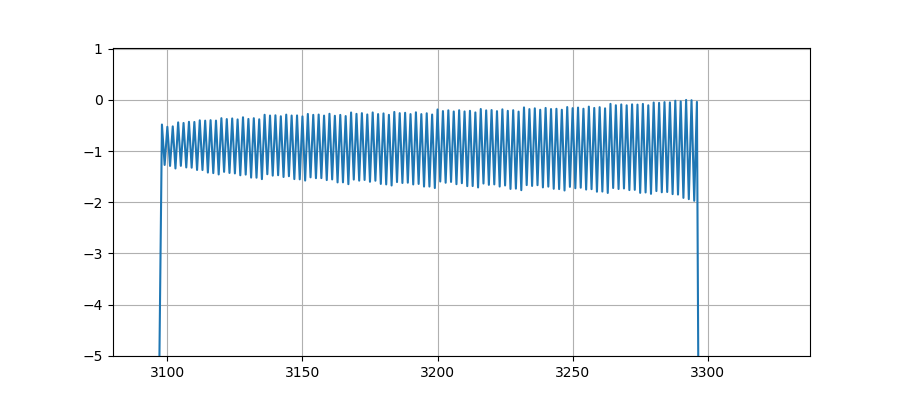

In [80]:
# SATURATE MIN EXP, MIN MAN
pyh = np.array(sims['PYHA'][0])
# pyh = [complex(x) for x in pyh]
pyh = pyh[bit_reversed_indexes(fft_size)]
pyh = np.fft.fftshift(pyh)
pyh = [complex(x) for x in pyh]
pyh = np.abs(pyh)
pyh = pyh / pyh.max()

a = 20 * np.log10(pyh)
plt.plot(a)
plt.grid()
plt.show()

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


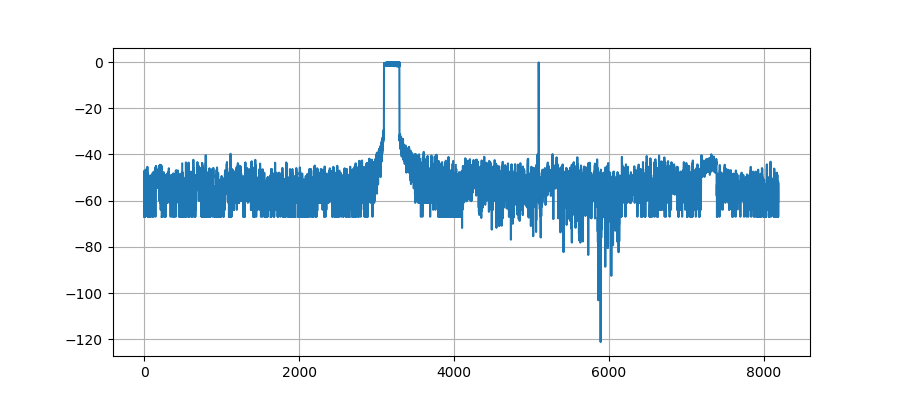

In [78]:
# SATURATE MIN EXP
pyh = np.array(sims['PYHA'][0])
# pyh = [complex(x) for x in pyh]
pyh = pyh[bit_reversed_indexes(fft_size)]
pyh = np.fft.fftshift(pyh)
pyh = [complex(x) for x in pyh]
pyh = np.abs(pyh)
pyh = pyh / pyh.max()

a = 20 * np.log10(pyh)
plt.plot(a)
plt.grid()
plt.show()

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


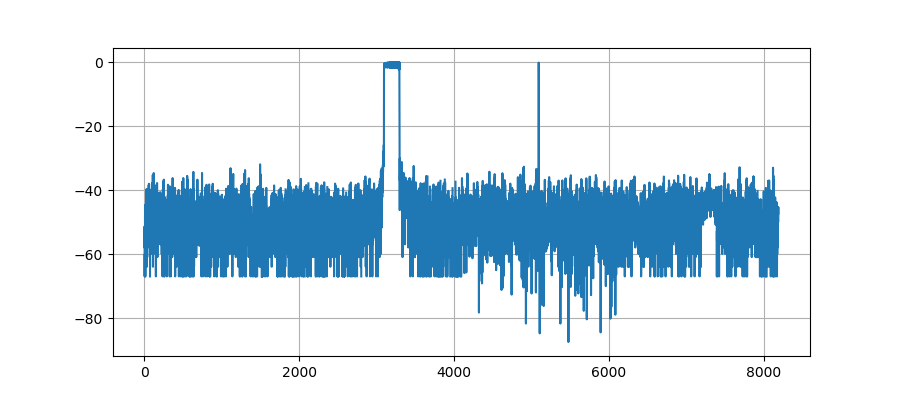

In [75]:
# SATURATE ZERO
pyh = np.array(sims['PYHA'][0])
# pyh = [complex(x) for x in pyh]
pyh = pyh[bit_reversed_indexes(fft_size)]
pyh = np.fft.fftshift(pyh)
pyh = [complex(x) for x in pyh]
pyh = np.abs(pyh)
pyh = pyh / pyh.max()

a = 20 * np.log10(pyh)
plt.plot(a)
plt.grid()
plt.show()

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


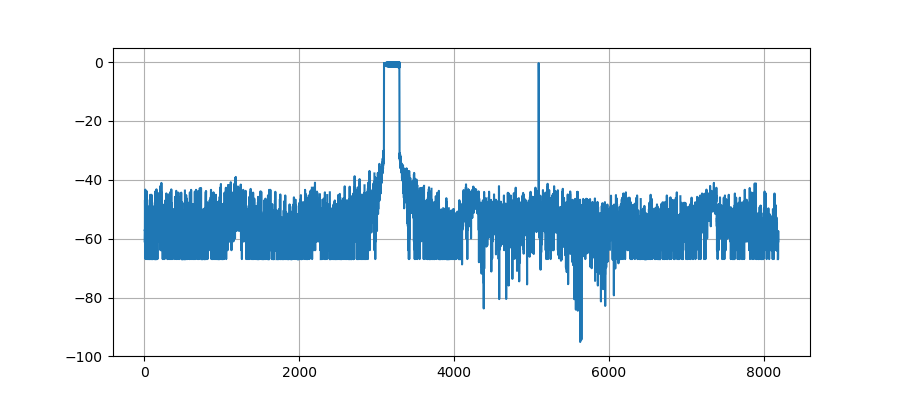

In [73]:
# R16 3, 15
pyh = np.array(sims['PYHA'][0])
# pyh = [complex(x) for x in pyh]
pyh = pyh[bit_reversed_indexes(fft_size)]
pyh = np.fft.fftshift(pyh)
pyh = [complex(x) for x in pyh]
pyh = np.abs(pyh)
pyh = pyh / pyh.max()

a = 20 * np.log10(pyh)
plt.plot(a)
plt.grid()
plt.show()

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


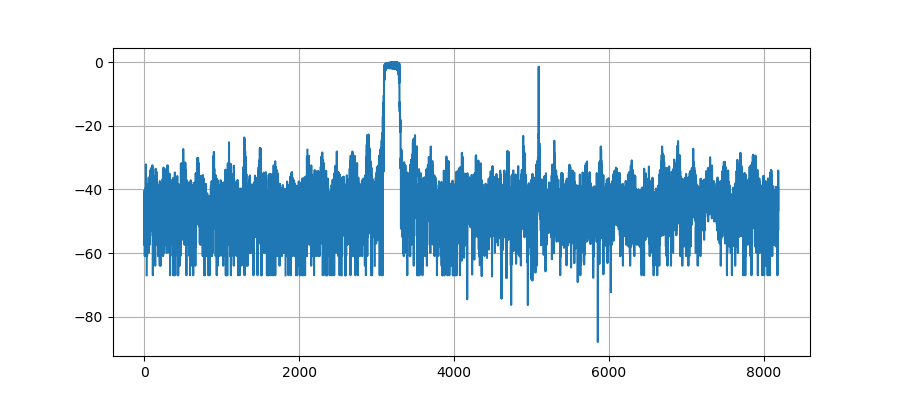

In [69]:
# R16 3, 15
pyh = np.array(sims['PYHA'][0])
# pyh = [complex(x) for x in pyh]
pyh = pyh[bit_reversed_indexes(fft_size)]
pyh = np.fft.fftshift(pyh)
pyh = [complex(x) for x in pyh]
pyh = np.abs(pyh)
pyh = pyh / pyh.max()

a = 20 * np.log10(pyh)
plt.plot(a)
plt.grid()
plt.show()

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


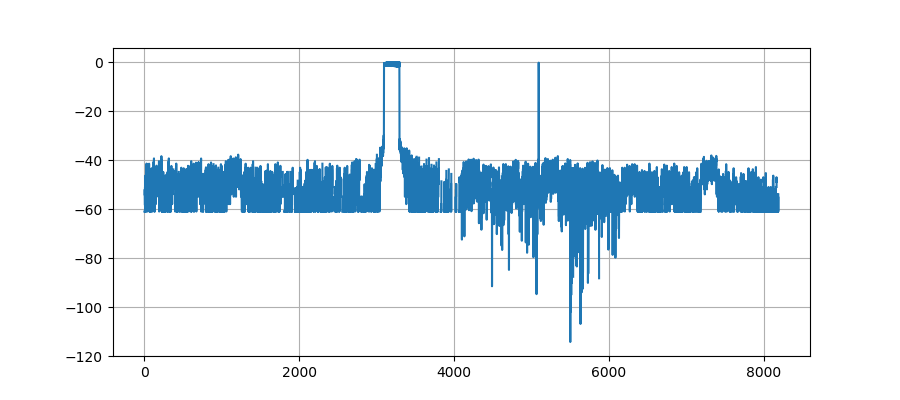

In [67]:
# 4, 14
pyh = np.array(sims['PYHA'][0])
# pyh = [complex(x) for x in pyh]
pyh = pyh[bit_reversed_indexes(fft_size)]
pyh = np.fft.fftshift(pyh)
pyh = [complex(x) for x in pyh]
pyh = np.abs(pyh)
pyh = pyh / pyh.max()

a = 20 * np.log10(pyh)
plt.plot(a)
plt.grid()
plt.show()

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


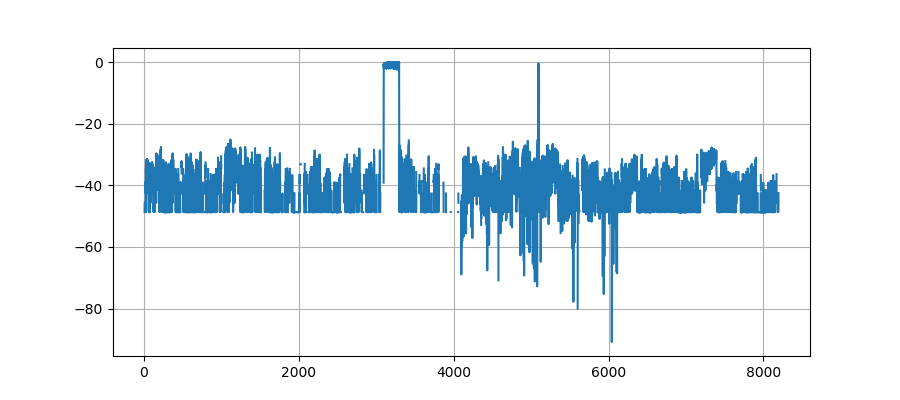

In [65]:
# 4, 12
pyh = np.array(sims['PYHA'][0])
# pyh = [complex(x) for x in pyh]
pyh = pyh[bit_reversed_indexes(fft_size)]
pyh = np.fft.fftshift(pyh)
pyh = [complex(x) for x in pyh]
pyh = np.abs(pyh)
pyh = pyh / pyh.max()

a = 20 * np.log10(pyh)
plt.plot(a)
plt.grid()
plt.show()

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


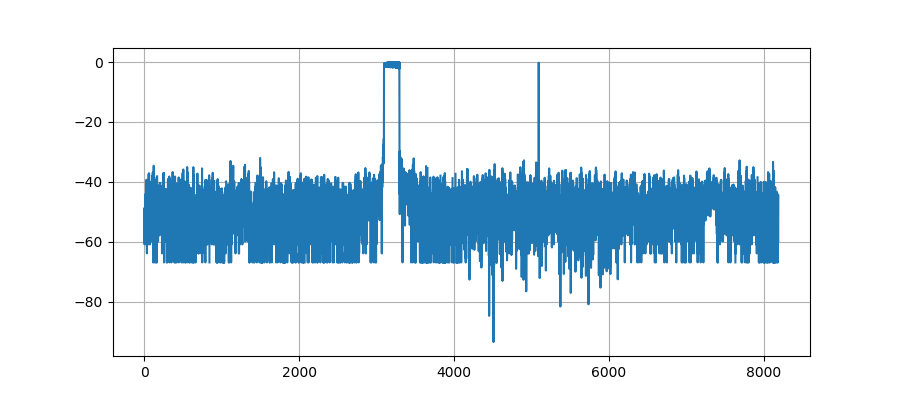

In [63]:
# 3, 15
pyh = np.array(sims['PYHA'][0])
# pyh = [complex(x) for x in pyh]
pyh = pyh[bit_reversed_indexes(fft_size)]
pyh = np.fft.fftshift(pyh)
pyh = [complex(x) for x in pyh]
pyh = np.abs(pyh)
pyh = pyh / pyh.max()

a = 20 * np.log10(pyh)
plt.plot(a)
plt.grid()
plt.show()

In [ ]:
pyh = np.array(sims['PYHA'][0])
# pyh = [complex(x) for x in pyh]
pyh = pyh[bit_reversed_indexes(fft_size)]
pyh = np.fft.fftshift(pyh)
pyh = [complex(x) for x in pyh]
pyh = np.abs(pyh)
pyh = pyh / pyh.max()

a = 20 * np.log10(pyh)
plt.plot(a)
plt.grid()
plt.show()